# ROC ML Training Pipeline

In [269]:
!pip install lightgbm pandas scikit-learn matplotlib


Defaulting to user installation because normal site-packages is not writeable


In [270]:
# Cell 2
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, accuracy_score, classification_report
import lightgbm as lgb


# # Create balanced synthetic dataset

generates 5000 rows perfectly balanced across all 5 classes.

In [271]:
# # Cell 3



# n = 5000
# labels = ["refurbish", "liquidate", "recycle", "donate", "keep_it"]
# n_each = int(n / len(labels))

# data = pd.DataFrame({
#     "category": np.random.choice(["Electronics", "Beauty", "Kitchen", "Apparel"], n),
#     "original_price": np.random.randint(100, 30000, n),
#     "condition_grade": np.random.choice(["A", "B", "C", "D"], n),
#     "return_reason_code": np.random.choice(["01", "02", "03", "04"], n),
#     "inbound_shipping_cost": np.random.randint(10, 300, n),
#     "hazardous_goods_flag": 0,
#     "co2_saved_refurb_vs_landfill": np.random.uniform(0.2, 10.0, n)
# })

# # Add label-specific logic
# for i, label in enumerate(labels):
#     start_idx = i * n_each
#     end_idx = (i + 1) * n_each
    
#     data.loc[start_idx:end_idx - 1, "final_decision"] = label

#     if label == "refurbish":
#         data.loc[start_idx:end_idx - 1, "profit"] = np.random.randint(5000, 15000, n_each)
#         data.loc[start_idx:end_idx - 1, "hazardous_goods_flag"] = 0

#     elif label == "liquidate":
#         data.loc[start_idx:end_idx - 1, "profit"] = np.random.randint(-3000, 1000, n_each)
#         data.loc[start_idx:end_idx - 1, "hazardous_goods_flag"] = 0

#     elif label == "recycle":
#         data.loc[start_idx:end_idx - 1, "profit"] = np.random.randint(-5000, 0, n_each)
#         data.loc[start_idx:end_idx - 1, "hazardous_goods_flag"] = 1

#     elif label == "donate":
#         data.loc[start_idx:end_idx - 1, "profit"] = np.random.randint(100, 500, n_each)
#         data.loc[start_idx:end_idx - 1, "hazardous_goods_flag"] = 0
#         data.loc[start_idx:end_idx - 1, "co2_saved_refurb_vs_landfill"] = np.random.uniform(4, 10, n_each)

#     elif label == "keep_it":
#         data.loc[start_idx:end_idx - 1, "profit"] = np.random.randint(10, 100, n_each)
#         data.loc[start_idx:end_idx - 1, "hazardous_goods_flag"] = 0
#         data.loc[start_idx:end_idx - 1, "original_price"] = np.random.randint(100, 800, n_each)

# print(data["final_decision"].value_counts())


In [272]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

np.random.seed(42)
n = 25000

# Categories and return reasons
categories = ["Electronics", "Beauty", "Kitchen", "Apparel"]
grade_probs = {"A": 0.3, "B": 0.4, "C": 0.2, "D": 0.1}
return_reasons = {
    "01_defective": ["recycle", "refurbish"],
    "02_changed_mind": ["keep_it", "liquidate"],
    "03_damaged_shipping": ["recycle", "liquidate"],
    "04_incorrect_item": ["liquidate", "donate"]
}

# Generate base dataset
data = pd.DataFrame({
    "category": np.random.choice(categories, n),
    "condition_grade": np.random.choice(list(grade_probs.keys()), n, p=list(grade_probs.values())),
    "return_reason": np.random.choice(list(return_reasons.keys()), n, p=[0.2, 0.5, 0.2, 0.1]),
    "original_price": np.random.randint(100, 30000, n),
    "inbound_shipping_cost": np.random.randint(50, 500, n),
})
  
# Bias toward refurbish/liquidate
def choose_decision(row):
    opts = return_reasons[row['return_reason']]
    # High-value refurbish
    if "refurbish" in opts and row["condition_grade"] in ("A","B") and row["original_price"] > 5000:
        return "refurbish"
    # Higher chance of liquidate for mid-value items
    if "liquidate" in opts and row["condition_grade"] in ("A","B","C"):
        return "liquidate" if np.random.rand() < 0.8 else np.random.choice(opts)
    # Otherwise fallback
    # Lower chance for keep_it and donate:
    choice = np.random.choice(opts, p=[
        0.05 if o in ["keep_it","donate"] else 0.475
        for o in opts
    ])
    return choice

data["final_decision"] = data.apply(choose_decision, axis=1)

# Profit ranges
profit_ranges = {
    'refurbish': (2000, 18000),
    'liquidate': (-2000, 1200),
    'recycle': (-5000, 1000),
    'donate': (0, 300),
    'keep_it': (10, 100)
}

# Initialize
data["hazardous_goods_flag"] = 0
data["co2_saved_refurb_vs_landfill"] = 0.0
data["profit"] = 0

# Populate flags and profit
for label, (lo, hi) in profit_ranges.items():
    mask = data["final_decision"] == label
    cnt = mask.sum()
    data.loc[mask, "profit"] = np.random.randint(lo, hi + 1, cnt)
    data.loc[mask, "hazardous_goods_flag"] = int(label == "recycle")
    if label == "refurbish":
        data.loc[mask, "co2_saved_refurb_vs_landfill"] = np.random.uniform(1, 5, cnt)
    elif label == "donate":
        data.loc[mask, "co2_saved_refurb_vs_landfill"] = np.random.uniform(4, 10, cnt)

# Ensure types
data["profit"] = data["profit"].astype(int)
data["hazardous_goods_flag"] = data["hazardous_goods_flag"].astype(int)

# Train/test split
train, test = train_test_split(
    data, test_size=0.2, stratify=data["final_decision"], random_state=42
)

train.to_csv("returns_train.csv", index=False)
test.to_csv("returns_test.csv", index=False)

print("🔸 Decision distribution:")
print(data["final_decision"].value_counts(normalize=True).round(3))


ValueError: probabilities do not sum to 1

# Feature Engineering
Convert text → numeric, and build useful features.

In [ ]:
# Cell 4

# Encode categorical variables
category_map = {
    "Electronics": 0,
    "Beauty": 1,
    "Kitchen": 2,
    "Apparel": 3
}

condition_map = {
    "A": 0,
    "B": 1,
    "C": 2,
    "D": 3
}

data["category"] = data["category"].map(category_map)
data["condition_grade"] = data["condition_grade"].map(condition_map)
data["return_reason_code"] = data["return_reason"].astype('category').cat.codes
data["hazardous_goods_flag"] = data["hazardous_goods_flag"].astype(int)



# Feature engineering
data["refurb_ratio"] = np.clip(
    np.random.uniform(0.05, 0.5, len(data)), 0, 1
)

data["resale_ratio"] = np.clip(
    np.random.uniform(0.2, 0.9, len(data)), 0, 1
)

data["estimated_refurb_cost"] = data["refurb_ratio"] * data["original_price"]
data["resale_value_estimated"] = data["resale_ratio"] * data["original_price"]


#  Prepare Data
Define your features and targets.

# preprocessing

In [ ]:
# Cell 5

features = data[[
    "category",
    "original_price",
    "condition_grade",
    "return_reason_code",
    "inbound_shipping_cost",
    "hazardous_goods_flag",
    "co2_saved_refurb_vs_landfill",
    "refurb_ratio",
    "resale_ratio",
    "profit"
]]

target_refurb_cost = data["estimated_refurb_cost"]
target_resale_value = data["resale_value_estimated"]
target_decision = data["final_decision"]




# preprocessing --- # Encode decision as numeric

In [ ]:

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

target_decision_encoded = le.fit_transform(target_decision)

# Save mapping for later

decision_mapping = dict(zip(
    le.transform(le.classes_), le.classes_
))
print(decision_mapping)

# Split Data Separately for Each Model

# Split for refurb cost prediction

----- feature = independent feature

and

---- estimated_refurb_cos = dependent feature

In [ ]:
# After generating original data ...

# Enhanced choice logic
def choose_decision(row):
    opts = return_reasons[row['return_reason']]
    if "refurbish" in opts and row["condition_grade"] in ("A","B") and row["original_price"] > 5000:
        return "refurbish"
    if "liquidate" in opts and row["condition_grade"] in ("A","B") and row["original_price"] < 5000:
        return "liquidate" if np.random.rand() < 0.7 else np.random.choice(opts)
    return np.random.choice(opts)

data["final_decision"] = data.apply(choose_decision, axis=1)

# Populate profit, flags, etc. (same as before)...

# Oversample refurbish & liquidate
oversampled = []
for label in ["refurbish", "liquidate"]:
    subset = data[data.final_decision == label]
    oversampled.append(subset.sample(frac=1.0, replace=True, random_state=42))
data_balanced = pd.concat([data] + oversampled, ignore_index=True)

# Now split
# train, test = train_test_split(data_balanced, test_size=0.2,
#                                stratify=data_balanced["final_decision"], random_state=42)


In [ ]:
X_refurb_train, X_refurb_test, y_refurb_train, y_refurb_test = train_test_split(
    features,
    target_refurb_cost,
    test_size=0.2,
    random_state=42
)



# Split for resale value prediction

----- feature = independent feature

and

---- resale_value_estimated  = dependent feature

In [ ]:

X_resale_train, X_resale_test, y_resale_train, y_resale_test = train_test_split(
    features,
    target_resale_value,
    test_size=0.2,
    random_state=42
)

# Split for decision classification

----- feature = independent feature

and

---- final_decision  = dependent feature

In [ ]:

X_decision_train, X_decision_test, y_decision_train, y_decision_test = train_test_split(
    features,
    target_decision_encoded,
    test_size=0.2,
    random_state=42,
    stratify=target_decision_encoded
)


# Train Model

All 3 models:

refurb cost

resale value

decision

# model selection 

# Refurb cost model

In [ ]:

model_refurb = lgb.LGBMRegressor(n_estimators=300, random_state=42)
model_refurb.fit(X_refurb_train, y_refurb_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000598 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1537
[LightGBM] [Info] Number of data points in the train set: 20000, number of used features: 10
[LightGBM] [Info] Start training from score 4165.504169


,boosting_type,'gbdt'
,num_leaves,31
,max_depth,-1
,learning_rate,0.1
,n_estimators,300
,subsample_for_bin,200000
,objective,None
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


# Resale value model

In [ ]:

model_resale = lgb.LGBMRegressor(n_estimators=300, random_state=42)
model_resale.fit(X_resale_train, y_resale_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000238 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1537
[LightGBM] [Info] Number of data points in the train set: 20000, number of used features: 10
[LightGBM] [Info] Start training from score 8308.126796


,boosting_type,'gbdt'
,num_leaves,31
,max_depth,-1
,learning_rate,0.1
,n_estimators,300
,subsample_for_bin,200000
,objective,None
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


# Decision classifier model

In [ ]:


model_decision = lgb.LGBMClassifier(
    n_estimators=300,
    class_weight="balanced",
    random_state=42
)
model_decision.fit(X_decision_train, y_decision_train)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000237 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1536
[LightGBM] [Info] Number of data points in the train set: 20000, number of used features: 10
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[L

,boosting_type,'gbdt'
,num_leaves,31
,max_depth,-1
,learning_rate,0.1
,n_estimators,300
,subsample_for_bin,200000
,objective,None
,class_weight,'balanced'
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


# performance metrics  strated from here ---------

# refurb model prediction

In [ ]:
pred_refurb = model_refurb.predict(X_refurb_test)

# Evaluate refurb cost

In [ ]:


mae_refurb = mean_absolute_error(y_refurb_test, pred_refurb)
print(f"MAE Refurb Cost: ₹{mae_refurb:.2f}")

MAE Refurb Cost: ₹31.12


# resale prediction

In [ ]:
pred_resale = model_resale.predict(X_resale_test)

# Evaluate resale value

In [ ]:



mae_resale = mean_absolute_error(y_resale_test, pred_resale)
print(f"MAE Resale Value: ₹{mae_resale:.2f}")


MAE Resale Value: ₹55.98


# decision model prediction

In [ ]:

pred_decision = model_decision.predict(X_decision_test)

# Evaluate decision model

In [ ]:


acc = accuracy_score(y_decision_test, pred_decision)
print(f"Decision Model Accuracy: {acc * 100:.2f}%")

print("\nClassification Report:\n")
print(classification_report(
    y_decision_test,
    pred_decision,
    target_names=le.classes_
))


Decision Model Accuracy: 99.18%

Classification Report:

              precision    recall  f1-score   support

      donate       1.00      1.00      1.00       241
     keep_it       0.97      1.00      0.98      1267
   liquidate       1.00      0.98      0.99      1988
     recycle       1.00      1.00      1.00       705
   refurbish       1.00      1.00      1.00       799

    accuracy                           0.99      5000
   macro avg       0.99      1.00      0.99      5000
weighted avg       0.99      0.99      0.99      5000




# Example rows for testing each model

In [ ]:
# Cell 9

examples = [
    ("Refurbish", {
        "category": 2,
        "original_price": 12000,
        "condition_grade": 0,
        "return_reason_code": 0,
        "inbound_shipping_cost": 100,
        "hazardous_goods_flag": 0,
        "co2_saved_refurb_vs_landfill": 3.5,
        "refurb_ratio": 0.08,
        "resale_ratio": 0.85,
        "profit": 7000
    }),
    ("Liquidate", {
        "category": 1,
        "original_price": 8000,
        "condition_grade": 3,
        "return_reason_code": 2,
        "inbound_shipping_cost": 300,
        "hazardous_goods_flag": 0,
        "co2_saved_refurb_vs_landfill": 0.5,
        "refurb_ratio": 0.6,
        "resale_ratio": 0.2,
        "profit": -2000
    }),
    ("Recycle", {
        "category": 0,
        "original_price": 25000,
        "condition_grade": 2,
        "return_reason_code": 3,
        "inbound_shipping_cost": 200,
        "hazardous_goods_flag": 1,
        "co2_saved_refurb_vs_landfill": 4.0,
        "refurb_ratio": 0.4,
        "resale_ratio": 0.2,
        "profit": -5000
    }),
    ("Donate", {
        "category": 3,
        "original_price": 3000,
        "condition_grade": 1,
        "return_reason_code": 1,
        "inbound_shipping_cost": 50,
        "hazardous_goods_flag": 0,
        "co2_saved_refurb_vs_landfill": 6.0,
        "refurb_ratio": 0.1,
        "resale_ratio": 0.6,
        "profit": 200
    }),
    ("Keep It", {
        "category": 1,
        "original_price": 500,
        "condition_grade": 0,
        "return_reason_code": 0,
        "inbound_shipping_cost": 10,
        "hazardous_goods_flag": 0,
        "co2_saved_refurb_vs_landfill": 0.2,
        "refurb_ratio": 0.05,
        "resale_ratio": 0.2,
        "profit": 20
    })
]

for label, row in examples:
    df = pd.DataFrame([row])

    refurb_pred = model_refurb.predict(df)[0]
    resale_pred = model_resale.predict(df)[0]
    decision_label = model_decision.predict(df)[0]
    decision_text = decision_mapping[decision_label]

    print(f"\n---- EXAMPLE: {label} ----")
    print(f"\n--------------------------------")
    print(f"Predicted Refurb Cost: ₹{refurb_pred:.2f}")
    print(f"Predicted Resale Value: ₹{resale_pred:.2f}")
    print(f"Recommended Decision: {decision_text}")



---- EXAMPLE: Refurbish ----

--------------------------------
Predicted Refurb Cost: ₹961.76
Predicted Resale Value: ₹10197.19
Recommended Decision: refurbish

---- EXAMPLE: Liquidate ----

--------------------------------
Predicted Refurb Cost: ₹4017.13
Predicted Resale Value: ₹1632.14
Recommended Decision: liquidate

---- EXAMPLE: Recycle ----

--------------------------------
Predicted Refurb Cost: ₹10084.10
Predicted Resale Value: ₹5048.86
Recommended Decision: recycle

---- EXAMPLE: Donate ----

--------------------------------
Predicted Refurb Cost: ₹313.49
Predicted Resale Value: ₹1793.29
Recommended Decision: donate

---- EXAMPLE: Keep It ----

--------------------------------
Predicted Refurb Cost: ₹-5.39
Predicted Resale Value: ₹100.09
Recommended Decision: keep_it


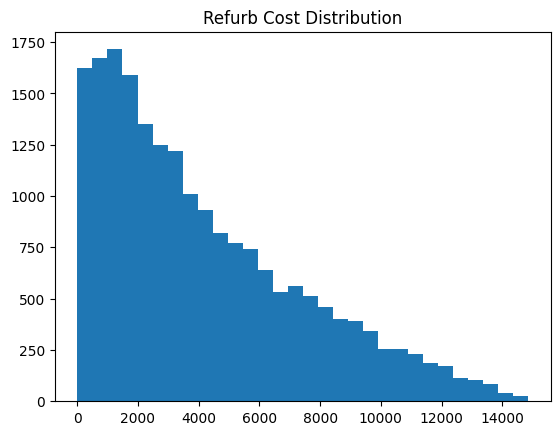

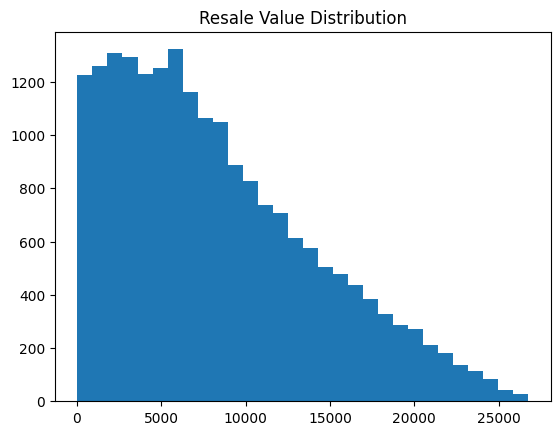

In [ ]:
import matplotlib.pyplot as plt

plt.hist(y_refurb_train, bins=30)
plt.title("Refurb Cost Distribution")
plt.show()

plt.hist(y_resale_train, bins=30)
plt.title("Resale Value Distribution")
plt.show()


# Save Models to Pickle

In [ ]:
import os
print("Working directory:", os.getcwd())


Working directory: d:\B-Tech CSE IIIT\B-Tech CSE IIIT\MACHINE_LEARNING_PROJECT\----------Hackathon -PROJECT------------\Walmart_model_train


In [ ]:
MODEL_DIR = "./models"  # relative to os.getcwd()
os.makedirs(MODEL_DIR, exist_ok=True)
print("Created/verified folder at:", os.path.abspath(MODEL_DIR))


Created/verified folder at: d:\B-Tech CSE IIIT\B-Tech CSE IIIT\MACHINE_LEARNING_PROJECT\----------Hackathon -PROJECT------------\Walmart_model_train\models


In [ ]:
import glob, pickle

# Remove old models
for path in glob.glob(os.path.join(MODEL_DIR, "*.pkl")):
    os.remove(path)

# Save new models
models = {
    "model_refurb.pkl": model_refurb,
    "model_resale.pkl": model_resale,
    "model_decision.pkl": model_decision,
    # "decision_mapping.pkl": decision_mapping
}
for filename, mdl in models.items():
    filepath = os.path.join(MODEL_DIR, filename)
    with open(filepath, "wb") as f:
        pickle.dump(mdl, f)
    print("✅ Saved:", filepath)


✅ Saved: ./models\model_refurb.pkl
✅ Saved: ./models\model_resale.pkl
✅ Saved: ./models\model_decision.pkl


In [ ]:
# import pickle

# # Save refurb cost model
# with open("model_refurb.pkl", "wb") as f:
#     pickle.dump(model_refurb, f)

# # Save resale value model
# with open("model_resale.pkl", "wb") as f:
#     pickle.dump(model_resale, f)

# # Save decision model
# with open("model_decision.pkl", "wb") as f:
#     pickle.dump(model_decision, f)

# # Save decision mapping
# with open("decision_mapping.pkl", "wb") as f:
#     pickle.dump(decision_mapping, f)

# print("✅ Models saved successfully.")
